# Authorship Verification

## Differences with the main notebook

The *Sidrac*, a prose text with a rhymed pro- and epilogue is included in this notebook, which complicates the analysis. Some functions are added to handle the text in different ways:

1) Option to remove the prose part of the *Sidrac* and only load in the (rhymed) pro- and epilogue;
2) Option to remove the rhyme words in all of the other works;
3) Option to limit the amount of segments per title in the scatterplot (otherwise e.g. *Spiegel Historiael* would dominate the plot).

Currently, option 2 and 3 are in use. Option 1 left too little data (222 verses).

## Loading in the needed libraries

In [1]:
import os
import re
from collections import Counter
import glob
from itertools import combinations, product

import lxml.etree
from tqdm import tqdm
import matplotlib.pyplot as plt
import pandas as pd
pd.set_option('display.max_colwidth', 0)
import numpy as np
np.random.seed(18012023)
import seaborn as sb

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import f1_score, precision_score, recall_score, precision_recall_curve
from sklearn.metrics import pairwise_distances
from sklearn.preprocessing import StandardScaler, normalize
from sklearn.cluster import AgglomerativeClustering
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier

import scipy.spatial.distance as scidist

from bokeh.models import HoverTool, ColumnDataSource
from bokeh.plotting import figure, show, output_file, save
from bokeh.io import output_file, show, save, output_notebook
from bokeh.plotting import figure
from bokeh.models import Axis

import mpl_axes_aligner

## Loading in the data  and metdata

#### Option to only load in the rhyme (option 1)

In [2]:
def load_verses(filepath, rm_interpol=True, rm_prose=False):
    tree = lxml.etree.parse(filepath)
    
    if rm_interpol:
        for interpolation in tree.xpath("//interpolation"):
            interpolation.getparent().remove(interpolation)
            
    if rm_prose:
        for prose in tree.xpath("//prose"):
            prose.getparent().remove(prose)
    
    verses = []
    
    for line_node in tree.iterfind('//l'):
        verse = []
        
        lemma_tags = [l.text if l.text else "" for l in line_node.iterfind('.//lemma')]
        pos_tags = [p.text if p.text else "" for p in line_node.iterfind('.//pos')]
        
        for lemma, pos in zip(lemma_tags, pos_tags):
            lemma = lemma or ""  # Ensure lemma is not None
            pos = pos or ""      # Ensure pos is not None
            
            for l, p in zip(lemma.split('+'), pos.split('+')):
                if p == 'NOU-P':
                    verse.append(('NOU-P', 'NOU-P'))
                else:
                    verse.append((l, p))
        
        verses.append(verse)
    
    return verses

In [3]:
meta_df = pd.read_excel('../data/metadata_corrected.xlsx')
meta_df = meta_df[meta_df['genre'].isin(['Epiek', 'Proza'])]
meta_df = meta_df[meta_df['exclude'] != 'x']
meta_df.sample(10)

id  \
80   grimbergse_oorlog_cont                               
166  roman_van_perchevael                                 
11   bediedenisse_van_der_missen                          
104  roman_van_lancelot_fragm_br                          
123  madelgijs_fragm_lo                                   
45   Der naturen bloeme, handschrift D                    
221  spiegel_historiael__2                                
99   roman_van_jonathas_ende_rosafiere_fragm_a            
40   cyromanchie_van_den_pape_van_den_hamme_chiromantie   
155  ongeidentificeerd_6                                  

                                      title              author provenance  \
80   Grimbergse oorlog (cont)                NaN                 cdrom-mnl   
166  Perchevael                              NaN                 cdrom-mnl   
11   Bediedenisse van der missen             NaN                 cdrom-mnl   
104  Lancelot                                NaN                 cdrom-mnl   
123  Madelgijs                               NaN                 cdrom-mnl   
45   Der naturen bloeme                      Jacob van Maerlant  CG1         
221  Spiegel historiael (P2)                 Philip Utenbroeke   cdrom-mnl   
99   Jonathas ende Rosafiere                 NaN                 cdrom-mnl   
40   Cyromanchie van den pape van den Hamme  NaN                 cdrom-mnl   
155  Ongeïdentificeerd (6)                   NaN                 cdrom-mnl   

    date_range  genre        subgenre exclude  
80   1300-1350  Epiek  Historiografie  NaN     
166  1300-1350  Epiek  Arthur          NaN     
11   1340-1360  Epiek  Religie         NaN     
104  1300-1350  Epiek  Arthur          NaN     
123  1350-1400  Epiek  Karel           NaN     
45   1287-1287  Epiek  Didactiek       NaN     
221  1393-1402  Epiek  Historiografie  NaN     
99   1500-1520  Epiek  Ridder          NaN     
40   1440-1460  Epiek  Didactiek       NaN     
155  1375-1400  Epiek  Karel           NaN

#### Works are loaded in, including the Sidrac:

In [4]:
meta_df.tail()

id                title                author provenance  \
282  willem_van_oringen  Willem van Oringen   NaN                   cdrom-mnl   
285  Wrake van Ragisel   Wrake van Ragisel    NaN                   CG1         
286  wrake_van_ragisel   Wrake van Ragisel    NaN                   cdrom-mnl   
287  Merlijn-Velthem     Merlijn-continuatie  Lodewijk van Velthem  cdrom-mnl   
288  sidrac              Sidrac               Jan van Boendale      cdrom-mnl   

    date_range  genre   subgenre exclude  
282  1300-1350  Epiek  Karel      NaN     
285  1280-1260  Epiek  Arthur     NaN     
286  1300-1350  Epiek  Arthur     NaN     
287  1415-1435  Epiek  Arthur     NaN     
288  1318-1329  Proza  Didactiek  NaN

In [5]:
works = []
rm_interpol = True

pbar = tqdm(meta_df.groupby('title'), desc='description')
for title, group in pbar:
    pbar.set_description('{message: <{width}}'.format(message=title[:50], width=50))
    meta = list(group.sample(1)[['title', 'author', 'genre', 'subgenre']].values[0])
    words = []
    
    for id_ in sorted(group['id']):
        try:
            words.extend(load_verses(f'../data/xml_galahad_BY-split/{id_}.xml', rm_interpol=rm_interpol))
        except OSError:
            print(f'- Could not load {id_}')
            continue
    
    works.append(meta + [words])

work_df = pd.DataFrame(works, columns=['title', 'author', 'genre', 'subgenre', 'text'])

Wrake van Ragisel                                 : 100%|█| 165/165 [00:09<00:00


In [6]:
work_df[work_df['title'] == 'Sidrac']

title            author  genre   subgenre  \
121  Sidrac  Jan van Boendale  Proza  Didactiek   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               

#### Option to delete all rhyme words in the other texts (might be more fair towards Sidrac) (option 2)


In [7]:
def remove_rhyme_words(row):
    # Leave Sidrac as is 
    if row['title'] == 'Sidrac':
        return row['text']
    else:
        new_text = []
        for inner_list in row['text']:
            # Remove last word of line
            if len(inner_list) > 0:
                new_inner_list = inner_list[:-1]
            else:
                new_inner_list = inner_list
            new_text.append(new_inner_list)
        return new_text

work_df['text'] = work_df.apply(remove_rhyme_words, axis=1)
work_df

title              author  genre       subgenre  \
0    Alexanders geesten    Jacob van Maerlant  Epiek  Ridder          
1    Alexiuslegende        NaN                 Epiek  Heiligenleven   
2    Anatomie van de mens  NaN                 Epiek  Didactiek       
3    Arturs doet           NaN                 Epiek  Arthur          
4    Aubri de Borgengoen   NaN                 Epiek  Karel           
..                   ...   ...                   ...    ...           
160  Walewein (Penninc)    Penninc             Epiek  Arthur          
161  Walewein (Vostaert)   Pieter Vostaert     Epiek  Arthur          
162  Walewein ende Keye    NaN                 Epiek  Arthur          
163  Willem van Oringen    NaN                 Epiek  Karel           
164  Wrake van Ragisel     NaN                 Epiek  Arthur          

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               

## Segmentation 

In [8]:
def segment(work_df, rhyme_only=True, incl_lemma=True, incl_pos=False, segment_length = 2000, min_length=1364):        
    if not (incl_pos or incl_lemma):
        raise ValueError('incl_lemma OR incl_pos must be set to True')

    segments = []

    for _, row in tqdm(list(work_df.iterrows())):
        if rhyme_only:
            text = [verse[-1] for verse in row['text']]
        else:
            text = [item for sublist in row['text'] for item in sublist]
        
        if incl_lemma and incl_pos:
            text = ['@'.join(p) for p in text]
        elif incl_lemma:
            text = [p[0] for p in text]
        else:
            text = [p[1] for p in text]

        meta = [row['title'], row['author'], row['genre'], row['subgenre']]
        
        if row['title'] == 'Van Saladijn':
            text = text[::2] + text[1::2]
        
        if segment_length:
            if len(text) < segment_length:
                continue
            si, ei, idx = 0, segment_length, 1
            while ei < len(text):
                segments.append(meta + [idx, text[si:ei]])
                idx += 1
                si += segment_length
                ei += segment_length
        else:
            if len(text) >= min_length:
                segments.append(meta + [0, text])

    return pd.DataFrame(segments, columns=['title', 'author', 'genre', 'subgenre', 'segment-idx', 'text'])

segment_df = segment(work_df, rhyme_only=False, incl_pos=False, segment_length=5000)
segment_df.sample(5)

100%|████████████████████████████████████████| 165/165 [00:00<00:00, 720.05it/s]


title                author  genre        subgenre  \
667  Walewein ende Keye       NaN                   Epiek  Arthur           
366  Rijmbijbel               Jacob van Maerlant    Epiek  Religie          
602  Spiegel historiael (P4)  Lodewijk van Velthem  Epiek  Historiografie   
354  Reinaerts historie       NaN                   Epiek  Dier             
443  Segheliin van Jerusalem  Loy Latewaert         Epiek  Kruisvaart       

     segment-idx  \
667  1             
366  4             
602  4             
354  5             
443  6             

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                  text  
667  [die, avontuur, doen, ons, dat, de, koning, nu, ter, houden, een, groot, om, te, meren, zijn, drie, duizend, ridder, over, zijn, nu, ten, eten, en, drie, honderd, ridder, talen, zijn, daar, van, de, die, altoos, zijn, met, nu, zeggen, ons, die, dat, de, koning, NOU-P, zijn, land, te, achterwaarne, en, al, dat, hij, doen, dat, zijn, dit, benijden, NOU-P, dat, NOU-P, aldus, schoon, dat, hij, zijn, de, koning, en, dat, land, algader, aan, hij, en, men, door, hij, alzo, niene, want, hij, drossaat, zijn, door, deze, ding, al, pijnen, gij, hij, hoe, hij, welwein, verraden, horden, wat, hij, hij, gaan, ...]                                    
366  [van, hij, zullen, zijn, en, menig, koning, NOU-P, beheten, hij, dat, land, dat, liggen, bij, de, NOU-P, beheten, hij, een, tussen, de, berg, en, de, van, deze, lessen, men, dat, hij, geboren, de, verrader, dan, spreken, hij, zullen, zijn, volk, hier, menen, gij, NOU-P, die, wel, kunnen, en, bestieren, zijn, en, geboren, zijn, van, ook, profiteren, hij, dat, antkersen, zullen, zijn, van, dan, geslacht, die, jegen, zullen, viseren, NOU-P, benedijen, hij, ook, en, beheten, hij, vechten, en, dat, geslacht, lessen, men, dat, voor, ander, met, groot, NOU-P, beheten, ook, dat, land, dat, zullen, dragen, haar, land, dat, hij, te, deel, ...]  
602  [niet, werken, nimmermeer, ne, kunnen, du, dat, in, NOU-P, zin, daar, ne, zijn, een, goed, aanschouwing, van, dat, men, du, zeggen, dat, te, in, dijn, hert, en, daar, en, met, geen, kwaadheid, van, nimmermeer, ne, verstaan, du, de, avitte, ook, in, geen, du, ne, lezen, eer, die, zullen, en, daarin, studeren, en, doen, en, als, du, zo, verstaan, na, zo, weten, du, wel, wat, NOU-P, en, aldus, zijn, het, van, al, daar, men, iet, willen, daarom, moeten, du, NOU-P, wet, van, ondervinden, en, oefenen, anders, zeggen, ik, in, waar, zo, ne, weten, du, niet, wat, zijn, du, ne, verstaan, wel, ...]                                                 
354  [goed, toen, gaan, hij, nederen, leggen, op, een, latier, maken, van, NOU-P, en, zijn, wijf, en, al, die, gaan, ook, slapen, maar, niet, zijn, met, zorg, zeer, hoe, hij, hij, goed, onschuldigen, oud, nacht, lachen, hij, ne, en, zoeken, in, hij, zelf, de, morgen, met, de, ruimen, hij, met, grimbaard, zijn, maar, eerst, zo, nemen, hij, schoon, aan, zijn, wijf, vrouw, en, ook, aan, die, kind, hij, spreken, laten, u, niet, ik, moeten, immer, te, houden, met, NOU-P, mijn, en, of, ik, iet, te, lang, daar, om, ne, zijn, niet, in, al, horen, gij, ook, enig, lid, die, zullen, du, ...]                                                             
443  [dat, gij, de, ridder, wil, hebben, daar, gij, kind, bij, hebben, en, hebben, te, breken, mijn, NOU-P, antwoorden, wel, heer, twij, laten, men, komen, NOU-P, die, weten, al, het, zijn, al, 

In [9]:
len(segment_df[segment_df['title'].str.contains('idrac')]['text'].iloc[0])

5000

## Combinations

In [10]:
calib_df = segment_df[
    (segment_df['author'].isin({'Jacob van Maerlant', 'Lodewijk van Velthem'})) | 
    (segment_df['title'].isin({'Jans teesteye'}))]
calib_df = calib_df[calib_df['title'] != 'Torec']
calib_df = calib_df[calib_df['title'] != 'Merlijn']

trg_df = segment_df[segment_df['title'].isin({#'Brabantsche yeesten (B1-3)', 
                                              #'Brabantsche yeesten (B4-5)',
                                              'Brabantsche yeesten (B5)',
                                              'Korte kroniek van Brabant (korte versie 1)',
                                              #'Korte kroniek van Brabant (lange versie)',
                                              'Der leken spieghel',
                                              'Jans teesteye',
                                              'Van den derden Eduwaert',
                                              'Melibeus',
                                              'Boec Exemplaer',
                                              'Dietsche doctrinale',
                                              'Boec vander wraken',
                                              'Sidrac'
                                             })] 

## Interpolations

The following interpolations are removed from the works. Based on Vandyck, C., & Kestemont, M. (2024). Een auteur van formaat. Een attributie-onderzoek naar het oeuvre van de Limborch-dichter. Spiegel Der Letteren, 66(2), 111–167. https://doi.org/10.2143/SDL.66.2.3293546)

Historie van Troyen (De Pauw & Gailliard 1889-1892, vs. 14587, vs. 16492, vs. 28332)

* vanaf vs. 14591 (Dies is leden menghen dach) t.e.m. vs. 15858 (Sonder haere beider lachter), ed. De Pauw & Gailliard 1889-1892.
* vanaf vs. 16493 (Daer waster veel syt, seker des) t.e.m. vs. 17500 (Dat seit Dares diet ons bescreef.), ed. De Pauw & Gailliard 1889-1892.
* vanaf vs. 28336 (Die werlt is gedeilt in drien) t.e.m. vs. 29344 (Sy en doyet gheen tyt), ed. De Pauw & Gailliard 1889-1892.

Spiegel Historiael, Vijfde Partie (Besamusca 2009, 83)

* vanaf boek I, kap. 40-46, vs. 2818 (Die derde Heinric van Brabant) t.e.m. vs. 3543 (Mar hier gaen vore ander dinge), ed. Vander Linden e.a. 1906-1938
* vanaf boek II, kap. 44-55, vs. 3213 (Na dit doen, dit es waer) t.e.m. vs. 3976 (Ward met enen stride gehint), ed. Vander Linden e.a. 1906-1938. 
* vanaf boek III, kap. 2-21, vs. 71 (In desen tiden, alse nu, gelach) t.e.m. vs. 1403 (In andren landen ende andren lieden), ed. Vander Linden e.a. 1906-1938.
* vanaf boek IV, vs. 1 (Nu es die tijt so verre comen) t.e.m. vs. 5329 (Den viften boec ende, ende volmaken), ed. Vander Linden e.a. 1906-1938.

Boec vander Wrake (Van Anrooij 1995, 44)

* vanaf boek III, vs. 2273 (Die hem wel bepeynsen soude) t.e.m. vs. 2490 (Amen seghet allegader. Amen), ed. Snellaert 1869.

Der vrouwen heimelijcheit (Van Doorn & Kuiper 1976-1977, 539) 

* vanaf vs. 824 (Ic soude u leeren, sonder waen) t.e.m. vs. 925 (Maer van den magdekine niet so saen,), ed. Blommaert 1846.

Dietsche Lucidarius (Klunder 2005, 80-88)30

* vanaf vs. 357 (Clerc, die here, die niene verstarf ) t.e.m. vs. 436 (Om die genuechte van aertrike), ed. Blommaert 1851.
* vanaf vs. 889 (Lieve meester, maect mi wijs) t.e.m. vs. 1026 (Mit saligen sielen scone;), ed. Blommaert 1851.
* vanaf vs. 4680 (Of men den lichame in ’t kerchof ) t.e.m. vs. 4810 (Daer die engelen Gode loven), ed. Blommaert 1851.

In [11]:
calib_df[['author', 'title']].value_counts()

author                title                          
Jacob van Maerlant    Spiegel historiael (P1-P4)         80
                      Historie van Troyen                35
                      Rijmbijbel                         31
Lodewijk van Velthem  Merlijn-continuatie                27
                      Spiegel historiael (P5)            18
Jacob van Maerlant    Der naturen bloeme                 15
                      Alexanders geesten                 12
                      Sinte Franciscus leven             9 
Lodewijk van Velthem  Spiegel historiael (P4)            6 
Jan van Boendale      Jans teesteye                      3 
Jacob van Maerlant    Heymelijchede der heymelijcheit    2 
Name: count, dtype: int64

In [12]:
trg_df[['title']].value_counts()

title                   
Der leken spieghel          19
Sidrac                      18
Dietsche doctrinale         6 
Boec vander wraken          5 
Brabantsche yeesten (B5)    3 
Jans teesteye               3 
Melibeus                    3 
Van den derden Eduwaert     1 
Name: count, dtype: int64

In [13]:
combos = []
authors_titles = [g for g, _ in calib_df.groupby(['author', 'title'])]
for c1, c2 in combinations(authors_titles, 2):
    if c1[0] == c2[0]:
        combos.append((c1[1], c2[1], 'S'))
    else:
        combos.append((c1[1], c2[1], 'D'))

combos = pd.DataFrame(combos, columns=['title1', 'title2', 'authorship'])
print(combos['authorship'].value_counts())
combos.sample(5)

authorship
D    31
S    24
Name: count, dtype: int64


title1                           title2  \
21  Heymelijchede der heymelijcheit  Sinte Franciscus leven            
10  Der naturen bloeme               Heymelijchede der heymelijcheit   
33  Historie van Troyen              Spiegel historiael (P5)           
53  Merlijn-continuatie              Spiegel historiael (P5)           
51  Jans teesteye                    Spiegel historiael (P5)           

   authorship  
21  S          
10  S          
33  D          
53  S          
51  D

In [14]:
def identity(x):
    return x

def bigrams(text):
    for i in range(len(text)-1):
        if 'NOU-P' not in text[i:i+2]:
            yield '-'.join((sorted(text[i:i+2])))
            
def unigrams(text):
    for i in range(len(text)):
        if 'NOU-P' not in text[i]:
            yield text[i]

params = {'use_idf': True,
          'max_features': 1000,
          'analyzer': unigrams,
          'min_df': 2}

vectorizer = TfidfVectorizer(**params)
vectorizer.fit(calib_df['text'].astype(str).tolist() + trg_df['text'].astype(str).tolist())
X = vectorizer.transform(calib_df['text'].astype(str).tolist()).toarray()
X.shape

(238, 66)

In [15]:
# Sanity check to make sure all proper nouns are ignored and not present in the vector (important for Korte Kroniek)

# get the features from the vectorizer
feature_names = vectorizer.get_feature_names_out()
contains_nou_p = any("NOU-P" in feature for feature in feature_names)

# result
print("Does the feature list contain 'NOU-P'?", contains_nou_p)

Does the feature list contain 'NOU-P'? False


### Calibration

In [16]:
calib_distances = []

for idx, row in combos.iterrows():
    AX = X[calib_df['title'] == row['title1']]
    BX = X[calib_df['title'] == row['title2']]
    
    for distance in scidist.cdist(AX, BX, metric='cosine').flatten():
        calib_distances.append((row['title1'], row['title2'], row['authorship'], distance))

calib_distances = pd.DataFrame(calib_distances, columns=['title1', 'title2', 'authorship', 'distance'])
calib_distances = calib_distances[~calib_distances['distance'].isna()]
calib_distances

title1                   title2 authorship  distance
0      Alexanders geesten       Der naturen bloeme       S          0.001368
1      Alexanders geesten       Der naturen bloeme       S          0.000419
2      Alexanders geesten       Der naturen bloeme       S          0.000455
3      Alexanders geesten       Der naturen bloeme       S          0.000613
4      Alexanders geesten       Der naturen bloeme       S          0.000289
...                   ...                      ...      ..               ...
23248  Spiegel historiael (P4)  Spiegel historiael (P5)  S          0.000406
23249  Spiegel historiael (P4)  Spiegel historiael (P5)  S          0.000801
23250  Spiegel historiael (P4)  Spiegel historiael (P5)  S          0.000810
23251  Spiegel historiael (P4)  Spiegel historiael (P5)  S          0.000824
23252  Spiegel historiael (P4)  Spiegel historiael (P5)  S          0.000746

[23253 rows x 4 columns]

max(f1)=0.0 @ theta=0.9992


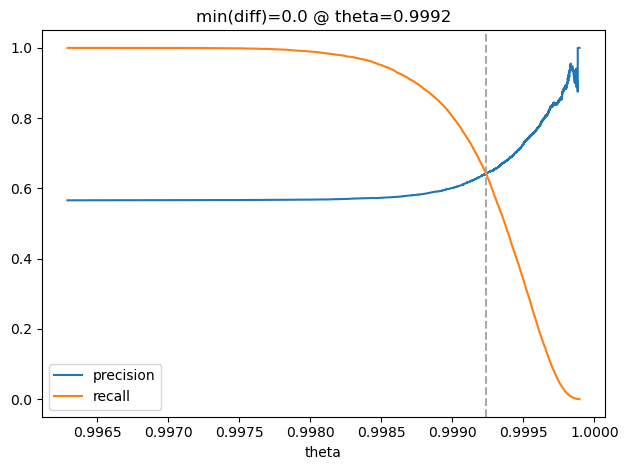

In [17]:
distances = 1 - np.array(calib_distances['distance'])
relevances = calib_distances['authorship']
precisions, recalls, thresholds = precision_recall_curve(relevances, distances, pos_label='S')
diffs = np.abs(precisions - recalls)
max_diff_idx = np.array(diffs).argmin()
max_diff = diffs[max_diff_idx]
max_diff_th = thresholds[max_diff_idx]
print(f'max(f1)={round(max_diff, 4)} @ theta={round(max_diff_th, 4)}')

plt.plot(thresholds, precisions[:-1], label='precision')
plt.plot(thresholds, recalls[:-1], label='recall')
plt.axvline(max_diff_th, ls='--', c='darkgrey')
plt.gca().set_xlabel('theta')
plt.gca().legend()
plt.title(f'min(diff)={round(max_diff, 4)} @ theta={round(max_diff_th, 4)}')
plt.tight_layout()

In [18]:
calib_thresh = 1 - max_diff_th
calib_thresh

0.0007623922791608617

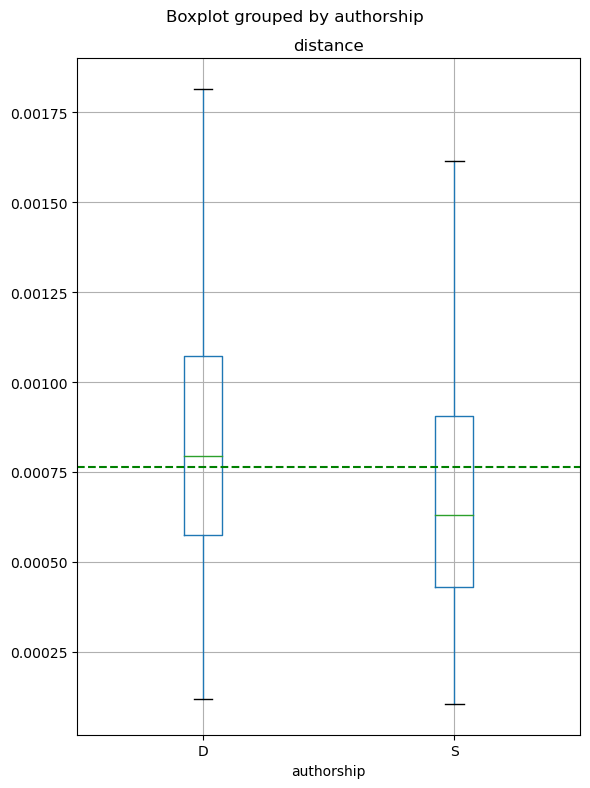

In [19]:
calib_distances.boxplot('distance', 'authorship', figsize=(6, 8), showfliers=False)
plt.axhline(calib_thresh, c='green', ls='--')
plt.tight_layout();

### Applied to the Antwerp School

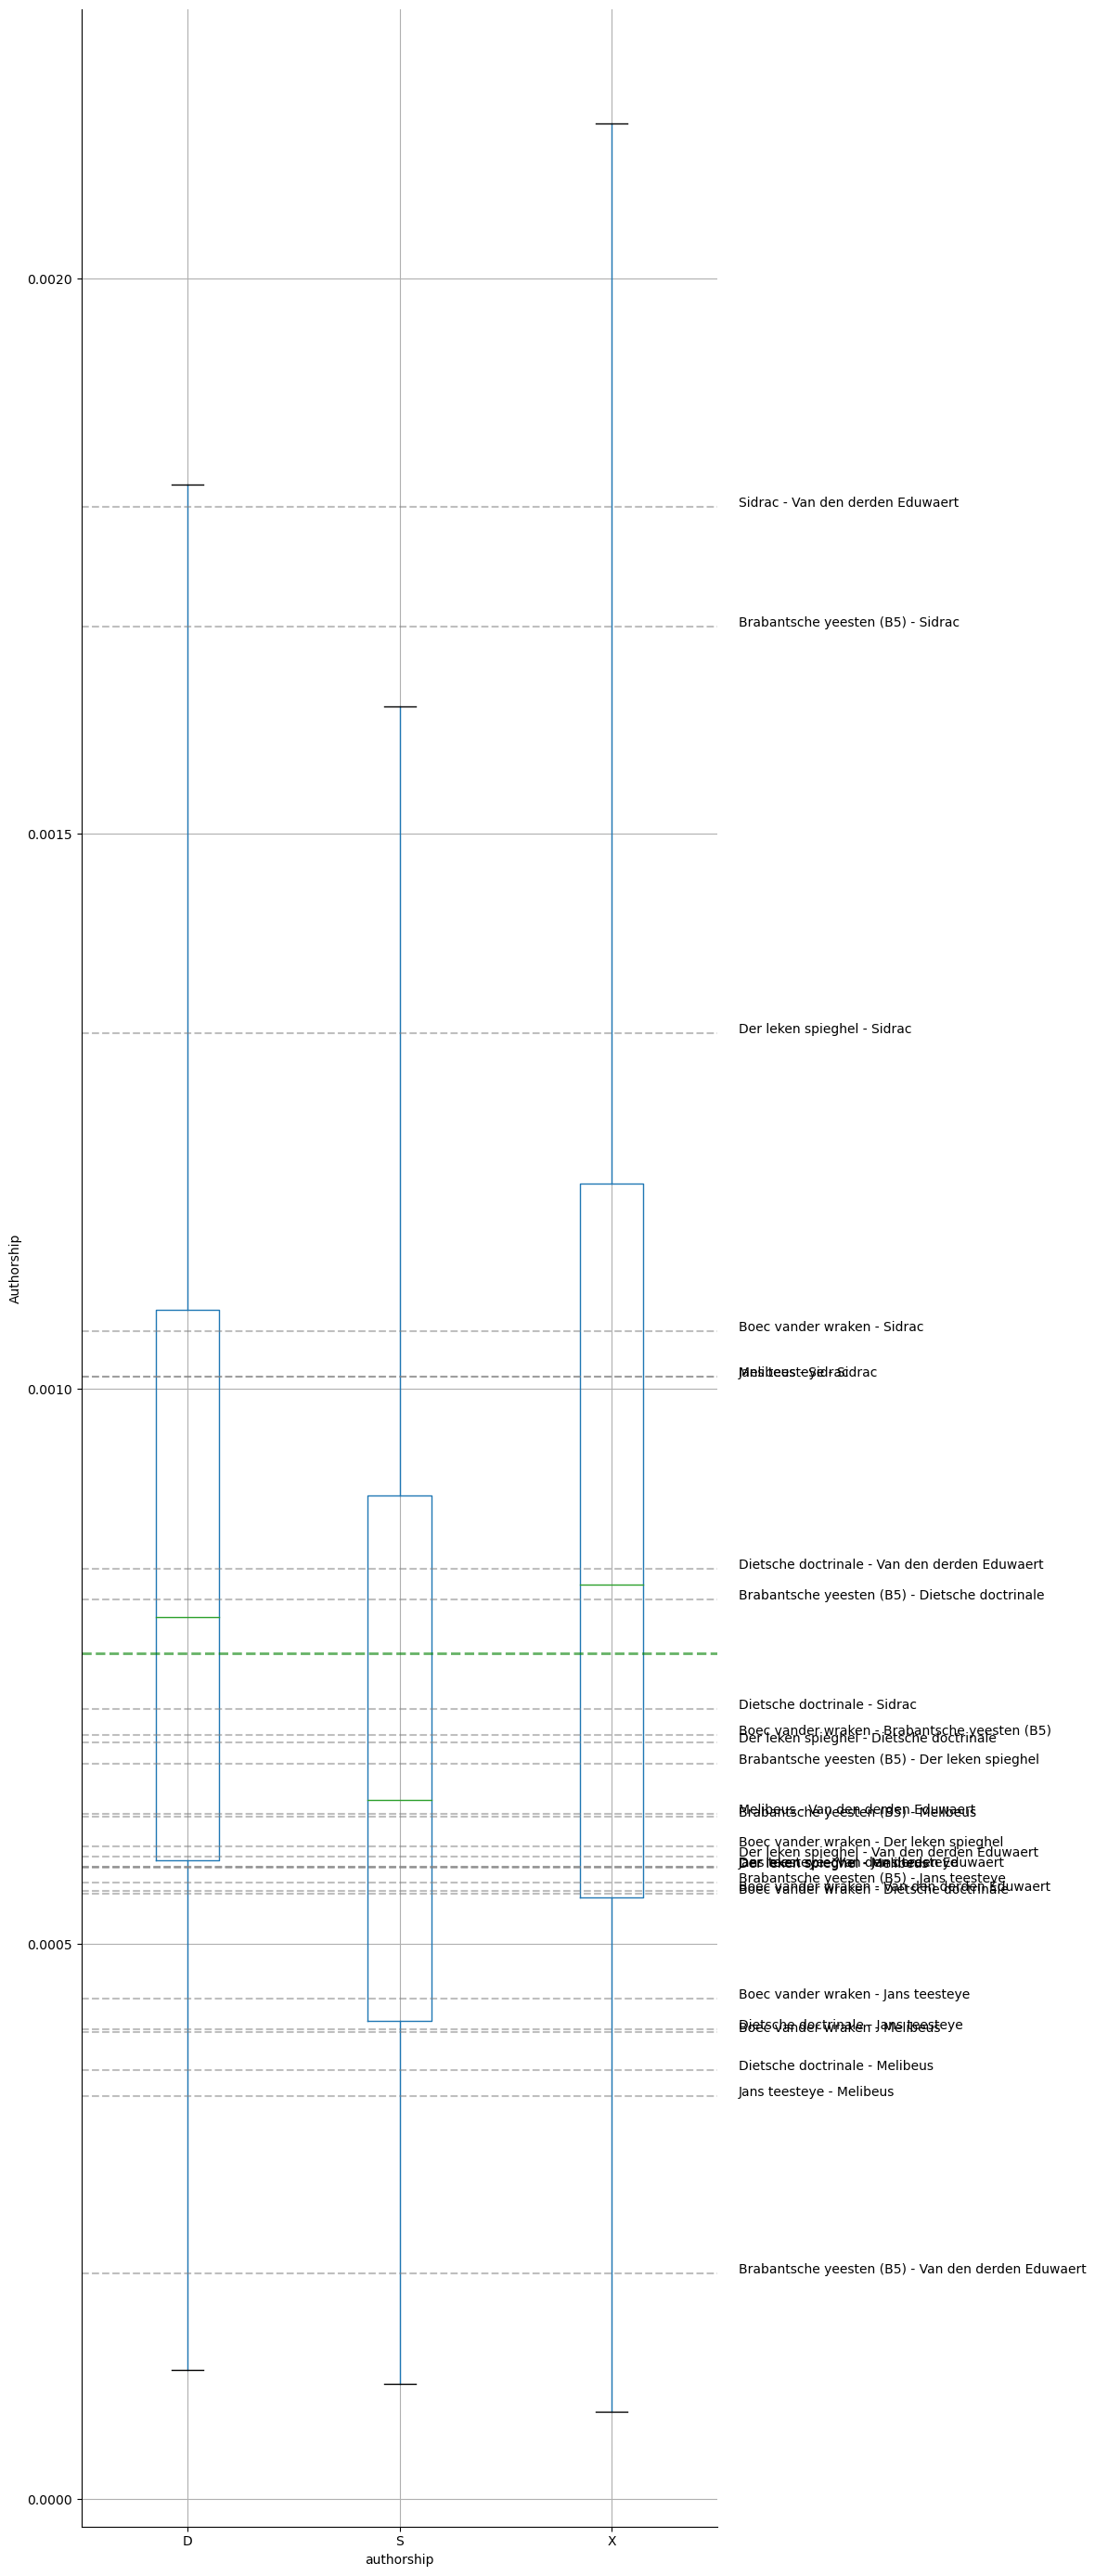

In [20]:
trg_X = vectorizer.transform(trg_df['text'].astype(str).tolist()).toarray()

combos = pd.DataFrame(combinations(trg_df['title'].unique(), 2), columns=['title1', 'title2'])
combos['authorship'] = 'X'

trg_distances = []

for idx, row in combos.iterrows():
    AX = trg_X[trg_df['title'] == row['title1']]
    BX = trg_X[trg_df['title'] == row['title2']]
    
    for distance in scidist.cdist(AX, BX, metric='cosine').flatten():
        trg_distances.append((row['title1'], row['title2'], row['authorship'], distance))

trg_distances = pd.DataFrame(trg_distances, columns=['title1', 'title2', 'authorship', 'distance'])
distances = pd.concat([calib_distances, trg_distances])

distances.boxplot('distance', 'authorship', figsize=(12, 28), showfliers=False)
sb.despine()
plt.axhline(calib_thresh, c='green', linewidth=2, ls='--', alpha=.6)

for grouper, group in distances.groupby('authorship'):
    if grouper == 'X':
        for m, d in group.groupby(['title1', 'title2'])['distance']:
            plt.gca().axhline(d.mean(), c='grey', ls='--', alpha=.5)
            plt.annotate(' - '.join(m), xy=[plt.gca().get_xlim()[1]+0.1, d.mean()],
                         annotation_clip=False)
            
plt.title('')
plt.ylabel('Distance')
plt.ylabel('Authorship')
plt.suptitle('')

plt.tight_layout();

## Networks

In [21]:
import umap.umap_ as umap

def scatterplot(X, df, label_column=None, color_column=None):
    if color_column:
        ints = [int(i) for i in LabelEncoder().fit_transform([str(i) for i in df[color_column]])]
        colors = sb.color_palette('husl', n_colors=len(set(ints)))
    else:
        ints = AgglomerativeClustering(n_clusters=8).fit_predict(X)
        colors = sb.color_palette('husl', n_colors=8)
    
    colors = [tuple([int(c * 256) for c in color]) for color in colors]
    
    meta_fields = ['title', 'genre', 'subgenre']
    d = {c:list(df[c]) for c in meta_fields}
    d['color'] = ['#%02x%02x%02x' % colors[i] for i in ints]
    d['x'] = X[:, 0]
    d['y'] = X[:, 1]
    source = ColumnDataSource(data=d)

    TOOLS="pan,wheel_zoom,reset,hover,box_select,save"

    p = figure(title='Embeddings',
               tools=TOOLS,
               width=1000,
               height=800,
               outline_line_color="white")

    p.circle(x='x', y='y', color='color',
             source=source, size=8,
             fill_alpha=0.9, line_color=None)
    
    if label_column:
        for label, x, y in zip(df[label_column], d['x'], d['y']):
            if isinstance(label, str):
                p.text(x, y, text=[label], text_align="center", text_font_size="5pt")

    hover = p.select(dict(type=HoverTool))
    hover.tooltips = [(c, '@'+c) for c in meta_fields]
    
    p.xgrid.grid_line_color = None
    p.ygrid.grid_line_color = None
    p.axis.axis_line_color = None
    p.axis.major_label_text_font_size = '0pt'

    # Turn off tick marks
    p.axis.major_tick_line_color = None
    p.axis[0].ticker.num_minor_ticks = 0
    p.axis[1].ticker.num_minor_ticks = 0
    
    show(p)
    
    return p

sub_df = segment_df[segment_df['subgenre'].isin({'Didactiek', 'Historiografie', 'Proza'})]
sub_df = sub_df[~sub_df['title'].isin({'Vlaamse Rose', 'Arturs doet', 'Merlijn-continuatie', 'Queeste van den Grale', 'Lancelot'})]
sub_df['text'] = sub_df['text'].apply(lambda x: ' '.join(x) if isinstance(x, list) else str(x))

# Option to limit amount of segments in the plot (option 3)
sub_df = sub_df.groupby('title').apply(lambda x: x.sample(n=min(len(x), 25), random_state=42)).reset_index(drop=True)

params = {'use_idf': True,
          'max_features': 500,
          'analyzer': 'word',
          'min_df': 5,
         }

vectorizer = TfidfVectorizer(**params)
BOW = vectorizer.fit_transform(sub_df['text']).toarray()
pca = PCA(n_components=20)
X = pca.fit_transform(BOW)

#tsne = TSNE(n_components=2)
#X = tsne.fit_transform(X)

umap_model = umap.UMAP(n_components=2, random_state=42, n_neighbors=25, min_dist=0.1)
X = umap_model.fit_transform(BOW)

plot = scatterplot(X, sub_df, label_column='title', color_column='title')
plot

/Users/carolinevandyck/anaconda3/lib/python3.11/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


figure(id='p1004', ...)

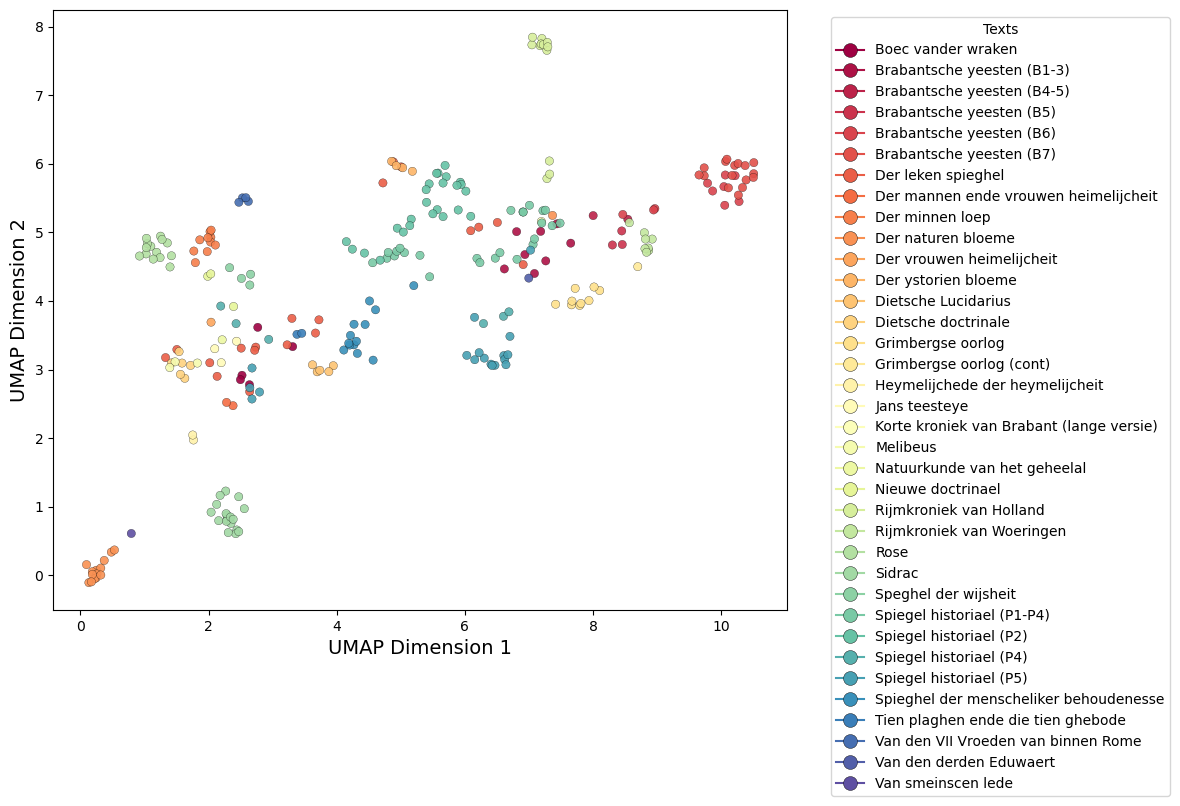

In [22]:
import umap.umap_ as umap

# Perform dimensionality reduction with PCA
pca_model = PCA(n_components=20)
X_pca = pca_model.fit_transform(BOW)

# Further reduction with UMAP
umap_model = umap.UMAP(n_components=2, n_neighbors=25, min_dist=0.1)#, n_neighbors=15, min_dist=0.1)
X_umap = umap_model.fit_transform(X_pca)

# Label encoding for scribes to color the scatter plot
label_encoder = LabelEncoder()
colors = label_encoder.fit_transform(sub_df['title'])

# Create a scatter plot with Matplotlib
plt.figure(figsize=(12, 8))
scatter = plt.scatter(X_umap[:, 0], X_umap[:, 1], c=colors, cmap='Spectral', alpha=0.9, edgecolor='black', linewidth=0.2)

# Creating a custom legend that matches the colors of the dots
text_labels = label_encoder.classes_
legend_handles = [plt.Line2D([0], [0], marker='o', color=scatter.cmap(scatter.norm(color)), label=f'{text}', markersize=10, markeredgecolor='black', markeredgewidth=0.3) for color, text in enumerate(text_labels)]

# Place the legend outside the plot on the right side, with a frame
plt.legend(handles=legend_handles, title="Texts", bbox_to_anchor=(1.05, 1), loc='upper left', frameon=True)

# Adding titles and labels with enhanced fonts
plt.xlabel('UMAP Dimension 1', fontsize=14)
plt.ylabel('UMAP Dimension 2', fontsize=14)
plt.grid(False)
plt.tight_layout()
#plt.savefig('../figures/scatterplot_with_legend_sidrac.svg', dpi=600, bbox_inches='tight')
plt.show()

In [23]:
import plotly.express as px
import pandas as pd

# Map categorical titles to a numeric scale for coloring
sub_df['title_numeric'] = pd.Categorical(sub_df['title']).codes

# Add UMAP coordinates back to the dataframe for ease of access
sub_df['UMAP Dimension 1'] = X_umap[:, 0]
sub_df['UMAP Dimension 2'] = X_umap[:, 1]

# Use a color scale based on the numeric mapping of titles
fig = px.scatter(sub_df, x='UMAP Dimension 1', y='UMAP Dimension 2', 
                 color='title_numeric', hover_data=['title'], 
                 labels={'title': 'title'}, 
                 color_continuous_scale='Spectral')  # You can change 'Viridis' to any other scale

# Add title and axis labels
fig.update_layout(title='UMAP Scatter Plot of Charter Texts by Scribes',
                  xaxis_title='UMAP Dimension 1',
                  yaxis_title='UMAP Dimension 2',
                  width=800,  # Adjust width
                  height=600,  # Adjust height to make it square
                  margin=dict(l=40, r=40, t=40, b=40)  # Adjust margins to avoid clipping
)

# Show interactive plot
fig.show()

In [24]:
# Want to include another text in sub_df? sub_df = segment_df[segment_df['title'].isin({''})]
sub_df = trg_df
sub_df['text'] = sub_df['text'].apply(lambda x: ' '.join(x) if isinstance(x, list) else str(x))

vectorizer = TfidfVectorizer(**params)
BOW = vectorizer.fit_transform(sub_df['text']).toarray()
BOW = StandardScaler().fit_transform(BOW)

/var/folders/qv/jgq1ttws58g43xdmt2gthgth0000gn/T/ipykernel_44869/1535423603.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



## PCA

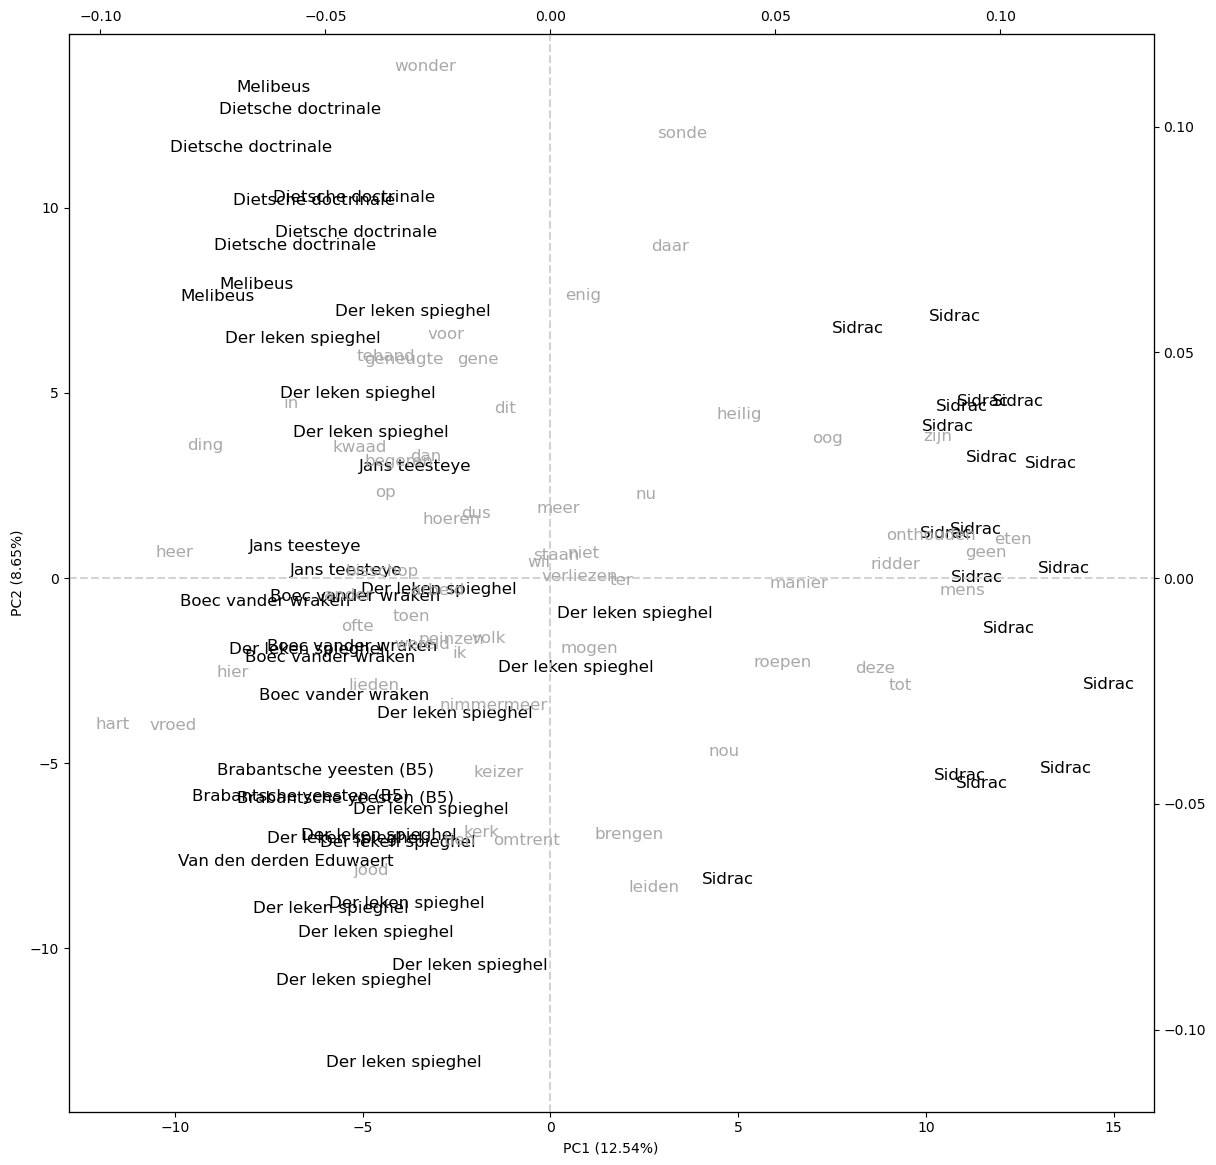

In [25]:
def plot_pca(document_proj, loadings, var_exp, labels):
    # first the texts:
    fig, text_ax = plt.subplots(figsize=(14, 14))
    x1, x2 = documents_proj[:, 0], documents_proj[:, 1]
    text_ax.scatter(x1, x2, facecolors='none')
    for p1, p2, label in zip(x1, x2, labels):
        text_ax.text(p1, p2, label, ha='center', va='center', fontsize=12)

    # add variance information to the axis labels:
    text_ax.set_xlabel(f'PC1 ({var_exp[0] * 100:.2f}%)')
    text_ax.set_ylabel(f'PC2 ({var_exp[1] * 100:.2f}%)')
    
    # now the loadings:
    loadings_ax = text_ax.twinx().twiny()
    l1, l2 = loadings[:, 0], loadings[:, 1]
    lc = l1 * l2
    m = 60
    top_idxs = lc.argsort()[::-1][:m]
    
    loadings_ax.scatter(l1[top_idxs], l2[top_idxs], facecolors='none');
    for x, y, loading in zip(l1, l2, np.array(vectorizer.get_feature_names_out())[top_idxs]):
        loadings_ax.text(x, y, loading, ha='center', va='center',
                         color='darkgrey', fontsize=12)

    mpl_axes_aligner.align.yaxes(text_ax, 0, loadings_ax, 0)
    mpl_axes_aligner.align.xaxes(text_ax, 0, loadings_ax, 0)
    
    # add lines through origins:
    plt.axvline(0, ls='dashed', c='lightgrey', zorder=0)
    plt.axhline(0, ls='dashed', c='lightgrey', zorder=0);

# fit the pca:
pca = PCA(n_components=2)
documents_proj = pca.fit_transform(BOW)
loadings = pca.components_.transpose()
var_exp = pca.explained_variance_ratio_

plot_pca(documents_proj, loadings, var_exp, sub_df['title'])

## Hierarchical clustering

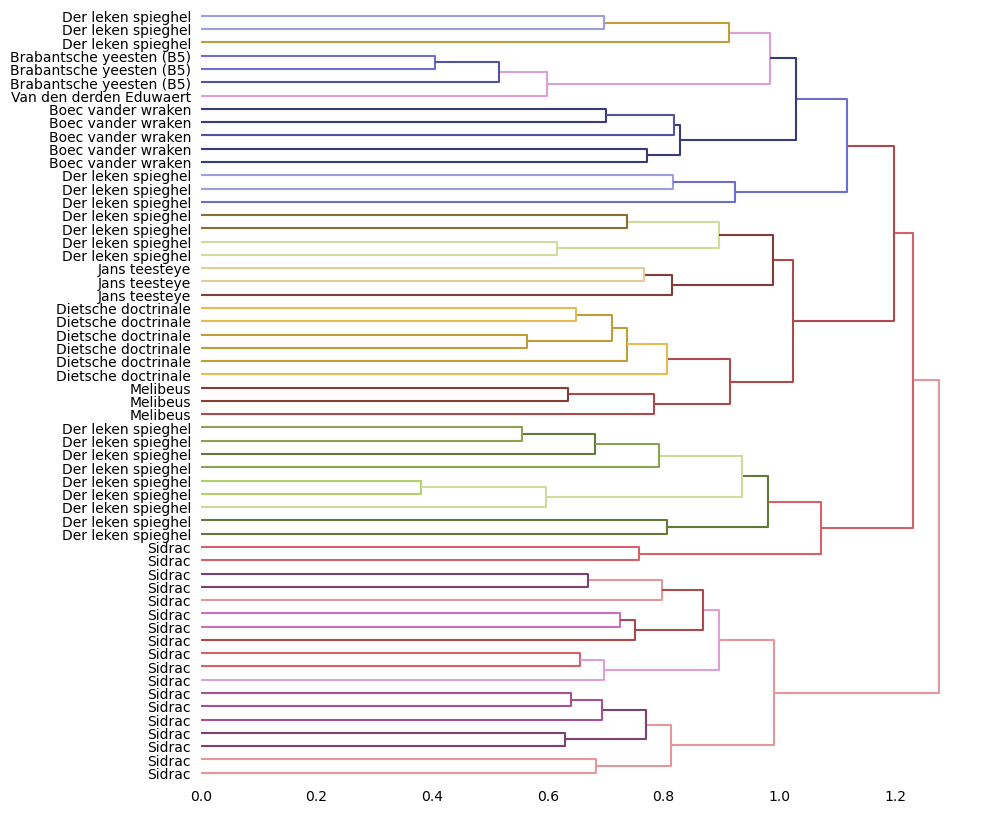

In [26]:
import matplotlib.pyplot as plt
import scipy.cluster.hierarchy as hierarchy
import scipy.spatial.distance as scidist
import numpy as np
import matplotlib.cm as cm
import matplotlib.colors as mcolors

# Reset index and get labels
trg_reset_df = trg_df.reset_index(drop=True)
labels = trg_reset_df['title'].tolist()

# Calculate pairwise distances and perform linkage
dm = scidist.pdist(BOW, 'cosine')
linkage_object = hierarchy.linkage(dm, method='complete')

# Assign a unique hex color to each leaf node
num_leaves = len(labels)
cmap = plt.colormaps['tab20b'].resampled(num_leaves)
colors = [mcolors.to_hex(cmap(i)) for i in range(num_leaves)]
leaf_colors = {i: colors[i % num_leaves] for i in range(num_leaves)}

# Function to color each branch path from leaves up
def color_func(link_id):
    if link_id < num_leaves:
        return leaf_colors[link_id]
    else:
        # Inherit color from the first child
        left = int(linkage_object[link_id - num_leaves][0])
        return color_func(left)

# Plot dendrogram
def plot_tree(linkage_object, labels, figsize=(10, 10), ax=None):
    if ax is None:
        fig, ax = plt.subplots(figsize=figsize)
    with plt.rc_context({'lines.linewidth': 1.5}):
        hierarchy.dendrogram(
            linkage_object, 
            labels=labels, 
            ax=ax,
            leaf_font_size=10,
            orientation='right',
            link_color_func=color_func
        )
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    for s in ax.spines.values():
        s.set_visible(False)

plot_tree(linkage_object, labels)

## Verification Ranking

In [27]:
params = {'use_idf': True,
          'max_features': 1000,
          'analyzer': 'word',
          'min_df': 2}

vectorizer = TfidfVectorizer(**params)
epics = segment_df[segment_df['genre'].isin(['Epiek', 'Proza'])].copy().reindex()
epics['text'] = epics['text'].apply(lambda x: ' '.join(x) if isinstance(x, list) else str(x))
vectorizer.fit(epics['text'])
segment_X = vectorizer.transform(epics['text']).toarray()
segment_X.shape

(674, 1000)

In [28]:
num_iter = 250
total_features = len(vectorizer.get_feature_names_out())
num_rnd_features = int(total_features * .5)
n_top_neighbors = 5

target_titles = [#'Brabantsche yeesten (B1-3)', 'Brabantsche yeesten (B4-5)',
                 'Korte kroniek van Brabant (lange versie)',
                 'Brabantsche yeesten (B5)', 'Korte kroniek van Brabant (korte versie 1)',
                 'Der leken spieghel', 'Jans teesteye', 'Van den derden Eduwaert', 
                 'Melibeus', 'Boec Exemplaer', 'Dietsche doctrinale', 'Boec vander wraken',
                 'Sidrac'
                ]

results = []

for target_title in target_titles:
    targets = epics[epics['title'] == target_title]
    candidates = epics[epics['title'] != target_title]
    neighbors = Counter()
    for trg_idx in tqdm(list(targets.index), desc=target_title):
        for i in range(num_iter):
            feats = np.random.choice(total_features, num_rnd_features, replace=False)
            ax = segment_X[trg_idx, feats]
            sampled = candidates.groupby('title').sample(1)
            xx = segment_X[sampled.index][:, feats]
            distances = scidist.cdist([ax], xx, metric='cosine').flatten()
            idxs = distances.argsort()[:1]
            neighbors.update(sampled.iloc[idxs]['title'])
    top_neighbors = neighbors.most_common(n_top_neighbors)
    summed = sum(neighbors.values())
    top_neighbors = [f'{k} ({(v / summed) * 100:.2f}%)' for k, v in top_neighbors]
    
    results.append([target_title] + top_neighbors)
    
results = pd.DataFrame(results, columns=['Target']+[f'Rank {i + 1}' for i in range(n_top_neighbors)])
results

Brabantsche yeesten (B5): 100%|███████████████████| 3/3 [00:00<00:00,  4.07it/s]
Korte kroniek van Brabant (korte versie 1): 0it [00:00, ?it/s]
Melibeus: 100%|███████████████████████████████████| 3/3 [00:00<00:00,  4.07it/s]
Boec Exemplaer: 0it [00:00, ?it/s]
Sidrac: 100%|███████████████████████████████████| 18/18 [00:04<00:00,  3.96it/s]


Target  \
0   Korte kroniek van Brabant (lange versie)     
1   Brabantsche yeesten (B5)                     
2   Korte kroniek van Brabant (korte versie 1)   
3   Der leken spieghel                           
4   Jans teesteye                                
5   Van den derden Eduwaert                      
6   Melibeus                                     
7   Boec Exemplaer                               
8   Dietsche doctrinale                          
9   Boec vander wraken                           
10  Sidrac                                       

                                      Rank 1  \
0   Brabantsche yeesten (B1-3) (54.40%)        
1   Van den derden Eduwaert (50.27%)           
2   None                                       
3   Jans teesteye (19.26%)                     
4   Boec vander wraken (33.73%)                
5   Brabantsche yeesten (B5) (40.80%)          
6   Dietsche doctrinale (63.73%)               
7   None                                       
8   Melibeus (56.27%)                          
9   Jans teesteye (30.88%)                     
10  Heymelijchede der heymelijcheit (22.60%)   

                                 Rank 2                               Rank 3  \
0   Spiegel historiael (P1-P4) (20.40%)  Brabantsche yeesten (B4-5) (13.60%)   
1   Brabantsche yeesten (B4-5) (39.20%)  Rijmkroniek van Woeringen (4.80%)     
2   None                                 None                                  
3   Boec vander wraken (16.80%)          Dietsche doctrinale (6.82%)           
4   Der leken spieghel (14.13%)          Der minnen loep (7.47%)               
5   Brabantsche yeesten (B1-3) (30.80%)  Brabantsche yeesten (B4-5) (9.20%)    
6   Jans teesteye (18.53%)               Der leken spieghel (5.47%)            
7   None                                 None                                  
8   Jans teesteye (19.13%)               Der leken spieghel (10.73%)           
9   Der leken spieghel (16.24%)          Van den derden Eduwaert (11.04%)      
10  Boec vander wraken (12.38%)          Der leken spieghel (8.89%)            

                              Rank 4                              Rank 5  
0   Rijmkroniek van Holland (2.40%)   Rijmbijbel (2.00%)                  
1   Brabantsche yeesten (B6) (2.27%)  Spiegel historiael (P5) (0.80%)     
2   None                              None                                
3   Van den derden Eduwaert (5.62%)   Brabantsche yeesten (B1-3) (4.65%)  
4   Melibeus (7.33%)                  Dietsche doctrinale (6.93%)         
5   Boec vander wraken (3.60%)        Spiegel historiael (P1-P4) (2.80%)  
6   Boec vander wraken (5.47%)        Der minnen loep (2.00%)             
7   None                              None                                
8   Boec vander wraken (6.73%)        Der minnen loep (1.27%)             
9   Melibeus (6.40%)                  Spiegel historiael (P5) (5.28%)     
10  Jans teesteye (7.40%)             Dietsche Lucidarius (6.13%)

### Pro- and epilogue

It would of course be interesting to only keep the rhymed pro- and epilogue and compare that to the Antwerp School.
The pro- and epilogue are only 222 verses long, together. This is too short for our analysis, as can bee seen in the dataframe below:

![pro-epilogue-sidrac](../figures/pro-epilogue-sidrac.png)

## Feature analysis

On the Antwerp School (vs. all Middle Dutch epics)

In [29]:
BOW = pd.DataFrame(segment_X, columns=vectorizer.get_feature_names_out())
BOW.index = epics['title'].isin([#'Brabantsche yeesten (B1-3)', 'Brabantsche yeesten (B4-5)',
                                 'Brabantsche yeesten (B5)',
                                 'Korte kroniek van Brabant (korte versie 1)',
                                 'Korte kroniek van Brabant (lange versie)',
                                 'Der leken spieghel', 'Jans teesteye', 
                                 'Van den derden Eduwaert', 'Melibeus', 'Boec Exemplaer', 
                                 'Dietsche doctrinale', 'Boec vander wraken', 'Sidrac'])

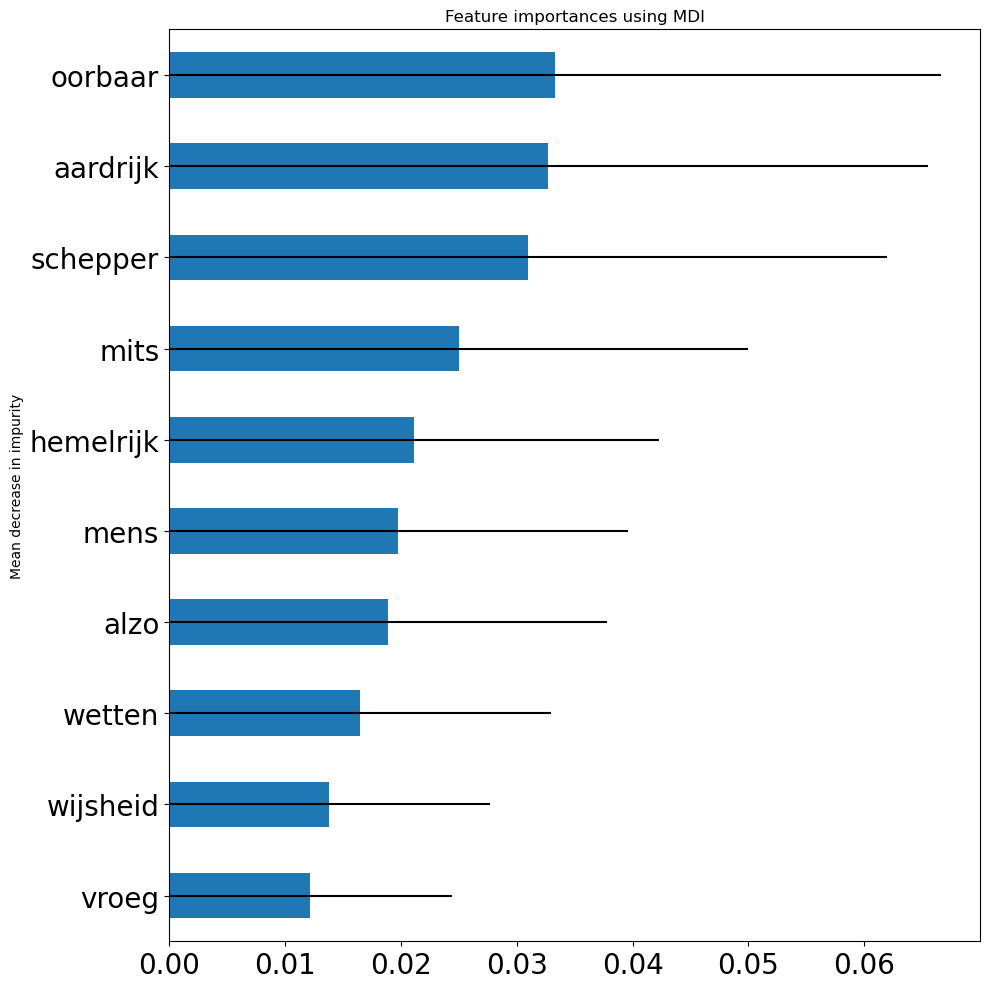

In [30]:
classes = BOW.index

feature_names = vectorizer.get_feature_names_out()
forest = RandomForestClassifier(random_state=0)
forest.fit(BOW, classes)

importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_], axis=0)

cutoff = 10
forest_importances = pd.Series(importances, index=feature_names)
std = pd.Series(std, index=feature_names)
forest_importances = forest_importances.sort_values(ascending=False).head(cutoff)[::-1]
std = forest_importances.loc[forest_importances.index].head(cutoff)[::-1]

fig, ax = plt.subplots(figsize=(10, 10))
forest_importances.plot.barh(xerr=std, ax=ax, fontsize=20)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

/Users/carolinevandyck/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning:

The figure layout has changed to tight



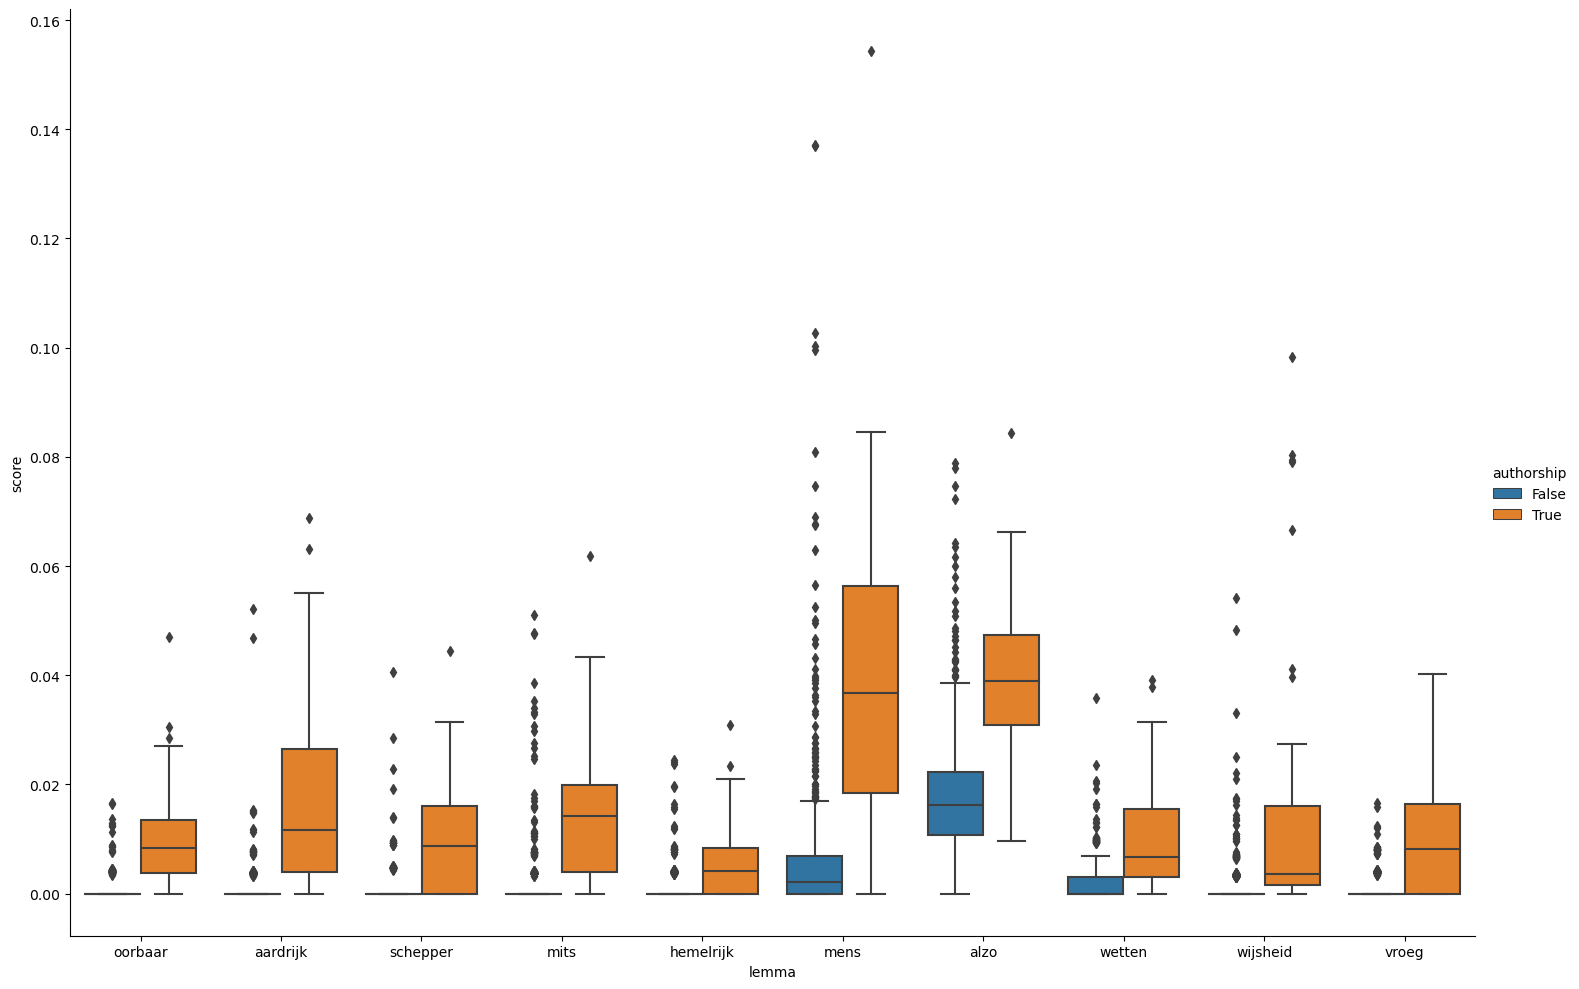

In [31]:
BOW = BOW[forest_importances.index[::-1]]
BOW.index = classes
bow = pd.melt(BOW, value_vars=BOW.columns, ignore_index=False, var_name='lemma', value_name='score')
bow = bow.reset_index()
bow['authorship'] = bow['title']
sb.catplot(x="lemma", hue="authorship", y="score", data=bow, kind='box', height=10, aspect=1.5);

## Sidrac

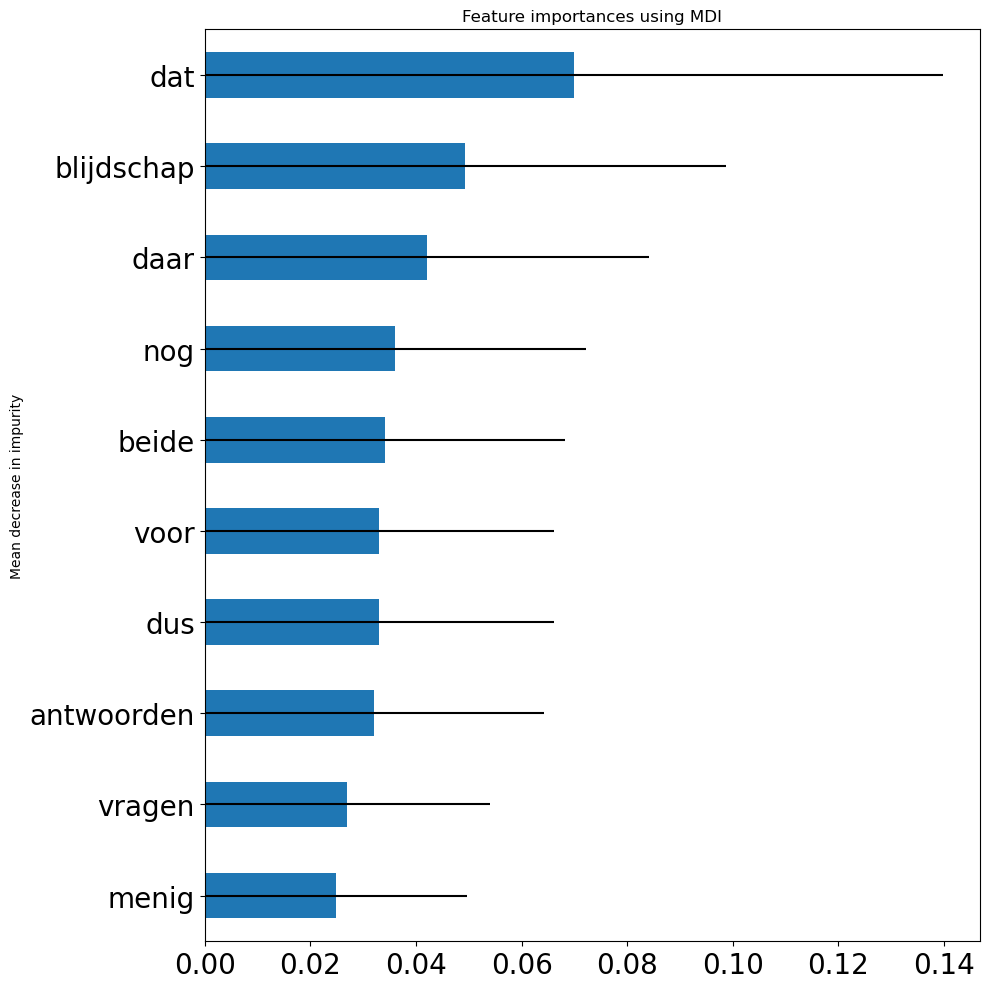

In [32]:
epics = epics[epics['title'].isin([#'Brabantsche yeesten (B1-3)', 'Brabantsche yeesten (B4-5)',
                                   'Brabantsche yeesten (B5)', 'Korte kroniek van Brabant (korte versie 1)',
                 'Der leken spieghel', 'Jans teesteye', 'Van den derden Eduwaert', 
                 'Melibeus', 'Boec Exemplaer', 'Dietsche doctrinale', 'Boec vander wraken', 'Sidrac'])]
segment_X = vectorizer.transform(epics['text']).toarray()

BOW = pd.DataFrame(segment_X, columns=vectorizer.get_feature_names_out())
BOW.index = epics['title'] == 'Sidrac'

classes = BOW.index

feature_names = vectorizer.get_feature_names_out()
forest = RandomForestClassifier(random_state=0)
forest.fit(BOW, classes)

importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_], axis=0)

cutoff = 10
forest_importances = pd.Series(importances, index=feature_names)
std = pd.Series(std, index=feature_names)
forest_importances = forest_importances.sort_values(ascending=False).head(cutoff)[::-1]
std = forest_importances.loc[forest_importances.index].head(cutoff)[::-1]

fig, ax = plt.subplots(figsize=(10, 10))
forest_importances.plot.barh(xerr=std, ax=ax, fontsize=20)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

/Users/carolinevandyck/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning:

The figure layout has changed to tight



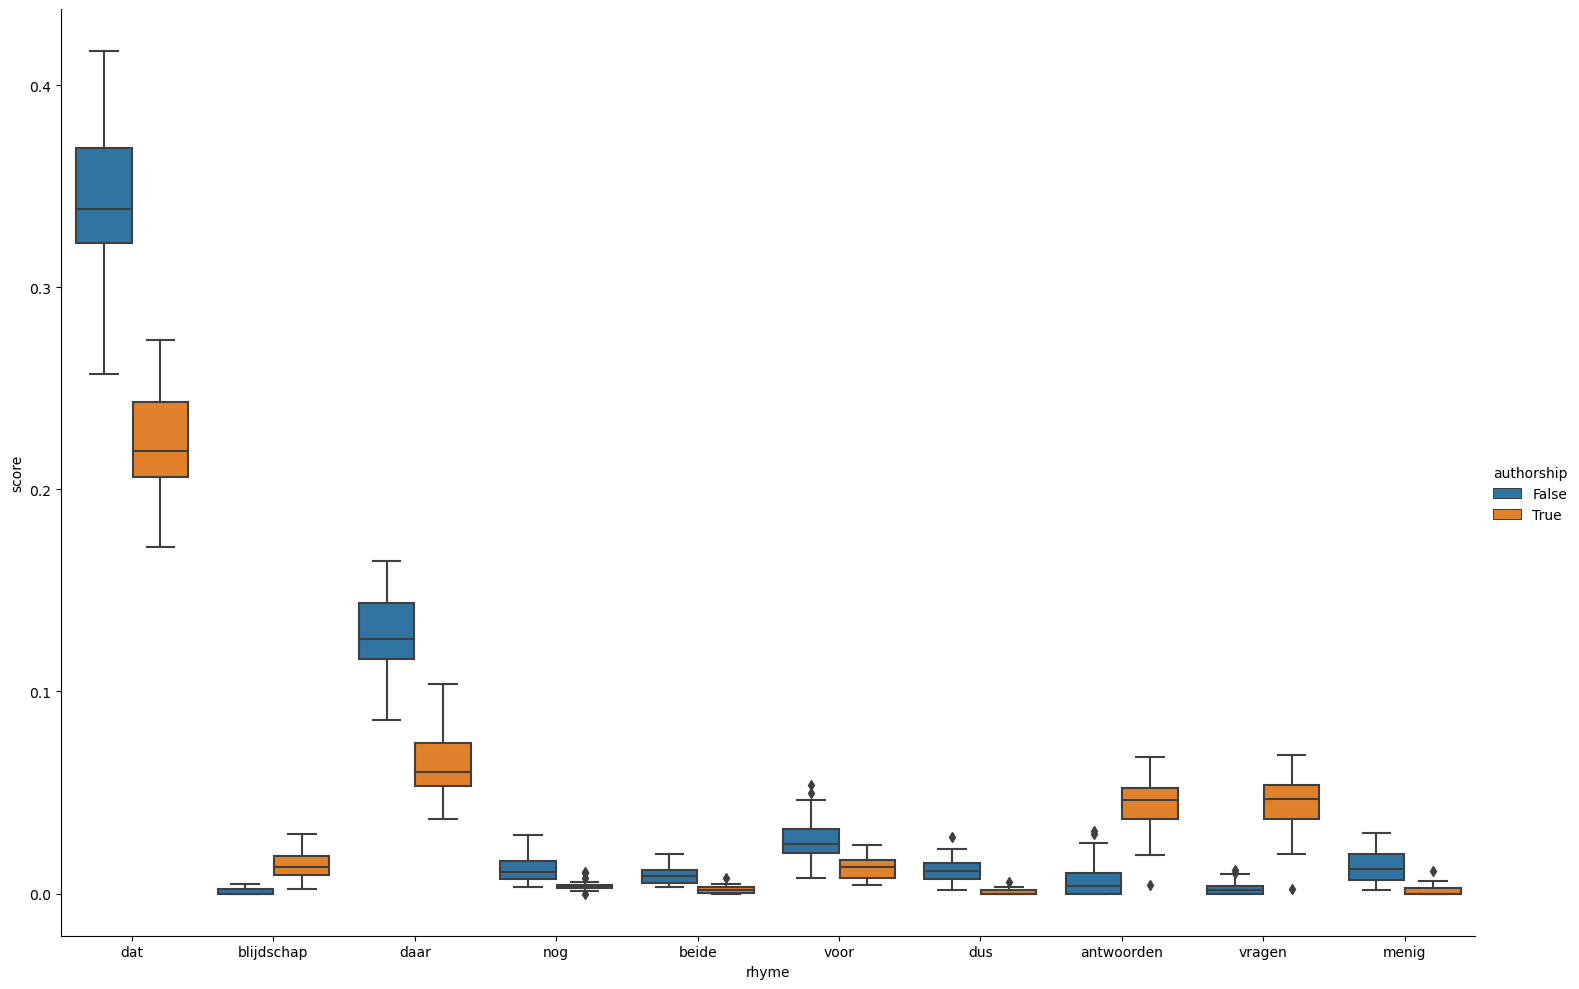

In [33]:
BOW = BOW[forest_importances.index[::-1]]
BOW.index = classes
bow = pd.melt(BOW, value_vars=BOW.columns, ignore_index=False, var_name='rhyme', value_name='score')
bow = bow.reset_index()
bow['authorship'] = bow['title']
sb.catplot(x="rhyme", hue="authorship", y="score", data=bow, kind='box', height=10, aspect=1.5);